In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import seaborn as sns


In [9]:
# Load data
edstays_df = pd.read_csv('edstays.csv')
diagnosis_df = pd.read_csv('diagnosis.csv')
triage_df = pd.read_csv('triage.csv')

In [10]:
# convert to object dtype
def convert_dtype(df, columns, dtype):
    for col in columns:
        if col in df.columns:
            try:
                df[col] = df[col].astype(dtype)
            except ValueError as e:
                print(f"Error converting column {col}, {e}")
        else:
            print(f"Column {col} does not exist in {df}")
    return df

In [11]:
columns = ["subject_id", "stay_id", "icd_version"]
diagnosis_df = convert_dtype(diagnosis_df, columns, object)

columns = ["subject_id", "hadm_id", "stay_id"]
edstays_df = convert_dtype(edstays_df, columns, object)

edstays_df["intime"] = pd.to_datetime(edstays_df["intime"])
edstays_df["outtime"] = pd.to_datetime(edstays_df["outtime"])

edstays_df = convert_dtype(edstays_df, ["gender"], bool)

columns = ["subject_id", "stay_id"]
triage_df = convert_dtype(triage_df, columns, object)

# this column contains mixed dtypes. Retain only numeric values
triage_df['pain'].value_counts()

# convert non-numeric values to NaN
triage_df['pain'] = pd.to_numeric(triage_df['pain'], errors='coerce')

# remove nans
triage_df.dropna(subset=['pain'], inplace=True)

triage_df = convert_dtype(triage_df, ["pain"], int)

#Merge all relevant dfs for analysis
df_combined = diagnosis_df.merge(edstays_df, on='stay_id', how='left', suffixes=('', '_ed'))
df_combined = df_combined.merge(triage_df, on='stay_id', how='left', suffixes=('', '_tri'))

df_combined.head()

,subject_id,stay_id,seq_num,icd_code,icd_version,icd_title,subject_id_ed,hadm_id,intime,outtime,...,subject_id_tri,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint
0,10000032,32952584,1,4589,9,HYPOTENSION NOS,10000032,29079034.0,2180-07-22 16:24:00,2180-07-23 05:54:00,...,10000032,97.8,87.0,14.0,97.0,71.0,43.0,7.0,2.0,Hypotension
1,10000032,32952584,2,07070,9,UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...,10000032,29079034.0,2180-07-22 16:24:00,2180-07-23 05:54:00,...,10000032,97.8,87.0,14.0,97.0,71.0,43.0,7.0,2.0,Hypotension
2,10000032,32952584,3,V08,9,ASYMPTOMATIC HIV INFECTION,10000032,29079034.0,2180-07-22 16:24:00,2180-07-23 05:54:00,...,10000032,97.8,87.0,14.0,97.0,71.0,43.0,7.0,2.0,Hypotension
3,10000032,33258284,1,5728,9,"OTH SEQUELA, CHR LIV DIS",10000032,22595853.0,2180-05-06 19:17:00,2180-05-06 23:30:00,...,10000032,98.4,70.0,16.0,97.0,106.0,63.0,0.0,3.0,"Abd pain, Abdominal distention"
4,10000032,33258284,2,78959,9,OTHER ASCITES,10000032,22595853.0,2180-05-06 19:17:00,2180-05-06 23:30:00,...,10000032,98.4,70.0,16.0,97.0,106.0,63.0,0.0,3.0,"Abd pain, Abdominal distention"


In [12]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899050 entries, 0 to 899049
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   subject_id         899050 non-null  object        
 1   stay_id            899050 non-null  object        
 2   seq_num            899050 non-null  int64         
 3   icd_code           899050 non-null  object        
 4   icd_version        899050 non-null  object        
 5   icd_title          899050 non-null  object        
 6   subject_id_ed      899050 non-null  object        
 7   hadm_id            421589 non-null  object        
 8   intime             899050 non-null  datetime64[ns]
 9   outtime            899050 non-null  datetime64[ns]
 10  gender             899050 non-null  bool          
 11  race               899050 non-null  object        
 12  arrival_transport  899050 non-null  object        
 13  disposition        899050 non-null  object  

In [13]:
# drop unnecessary columns
columns_to_drop = ["seq_num", "subject_id_ed", "hadm_id", "subject_id_tri", "subject_id", "stay_id", "icd_code", "chiefcomplaint","icd_version", "race", 
                   "arrival_transport", "disposition"]
df_combined.drop(columns_to_drop, axis=1, inplace=True)

df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899050 entries, 0 to 899049
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   icd_title    899050 non-null  object        
 1   intime       899050 non-null  datetime64[ns]
 2   outtime      899050 non-null  datetime64[ns]
 3   gender       899050 non-null  bool          
 4   temperature  818756 non-null  float64       
 5   heartrate    829567 non-null  float64       
 6   resprate     823395 non-null  float64       
 7   o2sat        823007 non-null  float64       
 8   sbp          827492 non-null  float64       
 9   dbp          826010 non-null  float64       
 10  pain         836429 non-null  float64       
 11  acuity       836060 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(8), object(1)
memory usage: 76.3+ MB


In [14]:
# count total Nan values
df_combined.isna().sum()

icd_title          0
intime             0
outtime            0
gender             0
temperature    80294
heartrate      69483
resprate       75655
o2sat          76043
sbp            71558
dbp            73040
pain           62621
acuity         62990
dtype: int64

In [15]:
df_combined.dropna(inplace=True)

df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800537 entries, 0 to 899048
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   icd_title    800537 non-null  object        
 1   intime       800537 non-null  datetime64[ns]
 2   outtime      800537 non-null  datetime64[ns]
 3   gender       800537 non-null  bool          
 4   temperature  800537 non-null  float64       
 5   heartrate    800537 non-null  float64       
 6   resprate     800537 non-null  float64       
 7   o2sat        800537 non-null  float64       
 8   sbp          800537 non-null  float64       
 9   dbp          800537 non-null  float64       
 10  pain         800537 non-null  float64       
 11  acuity       800537 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(8), object(1)
memory usage: 74.1+ MB


In [16]:
columns = ["temperature", "heartrate", "resprate", "o2sat", "sbp", "dbp", "pain"]
min_values = {col: df_combined[col].quantile(0.001) for col in columns}
min_values


{'temperature': 37.1,
 'heartrate': 40.0,
 'resprate': 12.0,
 'o2sat': 85.0,
 'sbp': 73.0,
 'dbp': 31.0,
 'pain': 0.0}

In [17]:
max_values = {col: df_combined[col].quantile(0.99) for col in columns}
max_values

{'temperature': 101.2,
 'heartrate': 130.0,
 'resprate': 24.0,
 'o2sat': 100.0,
 'sbp': 200.0,
 'dbp': 116.0,
 'pain': 13.0}

In [18]:
#filter values lower than 0.001 quantile
for col, val in min_values.items():
    df_combined = df_combined[df_combined[col] > val]

#filter values greater than 0.99 quantile
for col, val in max_values.items():
    df_combined = df_combined[df_combined[col] <= val]

df_combined.describe()

,intime,outtime,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity
count,494530,494530,494530.000000,494530.000000,494530.000000,494530.000000,494530.000000,494530.000000,494530.000000,494530.000000
mean,2156-10-23 09:58:47.133846528,2156-10-23 17:11:16.428276736,98.035326,84.129580,17.391527,98.542100,135.616602,77.675502,6.811063,2.778088
min,2110-01-11 01:45:00,2110-01-11 07:04:00,37.200000,41.000000,13.000000,86.000000,74.000000,32.000000,1.000000,1.000000
25%,2136-10-16 08:31:00,2136-10-16 11:54:00,97.500000,72.000000,16.000000,98.000000,121.000000,68.000000,5.000000,2.000000
50%,2156-10-06 09:37:00,2156-10-06 11:54:27.000000512,98.000000,83.000000,18.000000,99.000000,134.000000,78.000000,7.000000,3.000000
75%,2177-01-02 18:09:30,2177-01-03 14:50:00,98.500000,95.000000,18.000000,100.000000,149.000000,87.000000,9.000000,3.000000
max,2212-01-27 20:34:00,2212-01-28 13:17:00,101.200000,130.000000,24.000000,100.000000,200.000000,116.000000,13.000000,5.000000
std,NaN,NaN,1.123250,15.932991,1.723356,1.787543,20.785362,13.748121,2.819430,0.618439


In [19]:
mimic_df =  df_combined.reset_index(drop=True)
mimic_df

,icd_title,intime,outtime,gender,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity
0,CIRRHOSIS OF LIVER NOS,2180-08-05 20:58:00,2180-08-06 01:44:00,True,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0
1,ABDOMINAL PAIN UNSPEC SITE,2180-08-05 20:58:00,2180-08-06 01:44:00,True,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0
2,ASYMPTOMATIC HIV INFECTION,2180-08-05 20:58:00,2180-08-06 01:44:00,True,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0
3,OTHER ASCITES,2180-06-26 15:54:00,2180-06-26 21:31:00,True,98.9,88.0,18.0,97.0,116.0,88.0,10.0,3.0
4,UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...,2180-06-26 15:54:00,2180-06-26 21:31:00,True,98.9,88.0,18.0,97.0,116.0,88.0,10.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
494525,"Exposure to other specified factors, initial e...",2144-03-22 14:27:00,2144-03-22 18:47:00,True,97.7,89.0,22.0,100.0,176.0,109.0,10.0,3.0
494526,Weakness,2119-07-09 17:38:00,2119-07-10 00:04:00,True,98.0,91.0,16.0,99.0,148.0,90.0,5.0,2.0
494527,Fistula of intestine,2147-07-17 17:18:00,2147-07-18 17:34:00,True,98.1,83.0,18.0,100.0,107.0,75.0,8.0,2.0
494528,Type 2 diabetes mellitus with ketoacidosis wit...,2149-01-08 09:11:00,2149-01-08 18:12:00,True,96.6,112.0,18.0,100.0,110.0,82.0,4.0,2.0


In [20]:
mimic_df['LOS'] = (mimic_df["outtime"] - mimic_df["intime"]).dt.total_seconds()/3600
mimic_df.head()

,icd_title,intime,outtime,gender,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,LOS
0,CIRRHOSIS OF LIVER NOS,2180-08-05 20:58:00,2180-08-06 01:44:00,True,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0,4.766667
1,ABDOMINAL PAIN UNSPEC SITE,2180-08-05 20:58:00,2180-08-06 01:44:00,True,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0,4.766667
2,ASYMPTOMATIC HIV INFECTION,2180-08-05 20:58:00,2180-08-06 01:44:00,True,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0,4.766667
3,OTHER ASCITES,2180-06-26 15:54:00,2180-06-26 21:31:00,True,98.9,88.0,18.0,97.0,116.0,88.0,10.0,3.0,5.616667
4,UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...,2180-06-26 15:54:00,2180-06-26 21:31:00,True,98.9,88.0,18.0,97.0,116.0,88.0,10.0,3.0,5.616667


In [21]:
# Check data type
print("Data Type of 'acuity':", mimic_df['acuity'].dtype)

# Display unique values and their frequency distribution
print("Unique values in 'acuity':", mimic_df['acuity'].unique())
print("Value counts in 'acuity':",mimic_df['acuity'].value_counts())

Data Type of 'acuity': float64
Unique values in 'acuity': [3. 2. 4. 1. 5.]
Value counts in 'acuity': acuity
3.0    309518
2.0    134532
4.0     40986
1.0      8796
5.0       698
Name: count, dtype: int64


In [22]:
# Random sampling: sample a fixed percentage or a fixed number of rows
sampled_df = mimic_df.sample(frac=0.10, random_state=1)  # For example, sample 50% of the data

# Select specific features and the label from the sampled DataFrame
features = sampled_df[['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity']]
labels = sampled_df['LOS']

# Optionally, combine the features and labels into a single DataFrame for review or further processing
sampled_df = features.copy()
sampled_df['LOS'] = labels

# Display the first few rows of the combined DataFrame to verify
print(sampled_df.head())
print(sampled_df.info())
print(sampled_df.describe())


#Split into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.7, shuffle=True, random_state=1)


#Code without sampling
#features = mimic_df[['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity']]
#labels = mimic_df['LOS']

# Optionally, combine the features and labels into a single DataFrame for review or further processing
#final_df = features.copy()
#final_df['LOS'] = labels

#Split into Training and Testing Sets
#X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.7, shuffle=True, random_state=1)


        temperature  heartrate  resprate  o2sat    sbp   dbp  pain  acuity  \
92600          98.0       80.0      16.0   96.0  115.0  57.0  13.0     3.0   
44476          96.6       50.0      18.0  100.0  140.0  90.0   6.0     3.0   
174010         97.0       76.0      18.0   96.0  116.0  78.0  13.0     3.0   
246608         98.4       77.0      18.0   98.0  124.0  64.0   4.0     3.0   
364165         98.0       86.0      14.0   97.0  146.0  89.0   3.0     3.0   

             LOS  
92600   6.416667  
44476   7.618333  
174010  6.933333  
246608  3.300000  
364165  7.100000  
<class 'pandas.core.frame.DataFrame'>
Index: 49453 entries, 92600 to 488471
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  49453 non-null  float64
 1   heartrate    49453 non-null  float64
 2   resprate     49453 non-null  float64
 3   o2sat        49453 non-null  float64
 4   sbp          49453 non-null  float64
 5   dbp       

In [23]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(34617, 8)
(14836, 8)
(34617,)
(14836,)


In [24]:
# Initialize the scaler for features
feature_scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = feature_scaler.fit_transform(X_train)

# Apply the same transformation to the test data
X_test_scaled = feature_scaler.transform(X_test)

# Initialize the scaler for the target
target_scaler = StandardScaler()

# Since y_train and y_test are likely in a 1D array, reshape for compatibility
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

In [25]:
# Print the first few entries of the scaled feature datasets
print("First few scaled features in training data:")
print(X_train_scaled[:5])  # Adjust the number for more or fewer rows

print("\nFirst few scaled features in testing data:")
print(X_test_scaled[:5])

# Print the first few entries of the scaled target datasets
print("\nFirst few scaled targets in training data:")
print(y_train_scaled[:5])

print("\nFirst few scaled targets in testing data:")
print(y_test_scaled[:5])


First few scaled features in training data:
[[-0.84131115  0.98942774  0.35606662  0.25659522  0.06664743 -0.98991401
   2.18917475  0.35523431]
 [ 1.36519741  0.98942774 -0.80681449 -0.85140448 -0.12523397 -0.40937844
  -1.70366721  0.35523431]
 [ 0.13935932  1.55238006  0.35606662  0.81059507 -0.36508573 -0.48194539
   1.12749058  0.35523431]
 [ 1.52864249  0.23882464 -0.80681449 -1.95940418 -0.36508573 -1.35274873
   1.12749058  0.35523431]
 [-0.02408576  0.73922671  3.84470996  0.81059507  1.45778759  1.69506297
   1.12749058 -1.25750618]]

First few scaled features in testing data:
[[-0.26925338 -0.38667794 -0.80681449  0.81059507 -0.84478923 -0.26424455
   1.12749058  0.35523431]
 [-0.35097591 -1.07473077  0.35606662  0.81059507  2.84892775  1.98533075
  -0.28808832  1.96797481]
 [ 0.13935932  0.73922671  0.35606662  0.81059507  0.88214338  0.02602323
   0.06580641  0.35523431]
 [-0.18753084 -0.63687897 -1.38825504  0.81059507 -1.08464098 -0.19167761
   2.18917475  0.35523431]
 [

In [26]:
# Initialize the SVR model with specific C and gamma values
svm_model = SVR(C=0.1, gamma=0.1)

# Train the model on the scaled training data
svm_model.fit(X_train_scaled, y_train_scaled.ravel())

# Predict on the scaled test data
y_pred_scaled = svm_model.predict(X_test_scaled)

# Convert predictions back to original scale
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Calculate the mean squared error on the original scale
mse = mean_squared_error(y_test, y_pred)
print("Test Mean Squared Error:", mse)

Test Mean Squared Error: 40.96610718652598


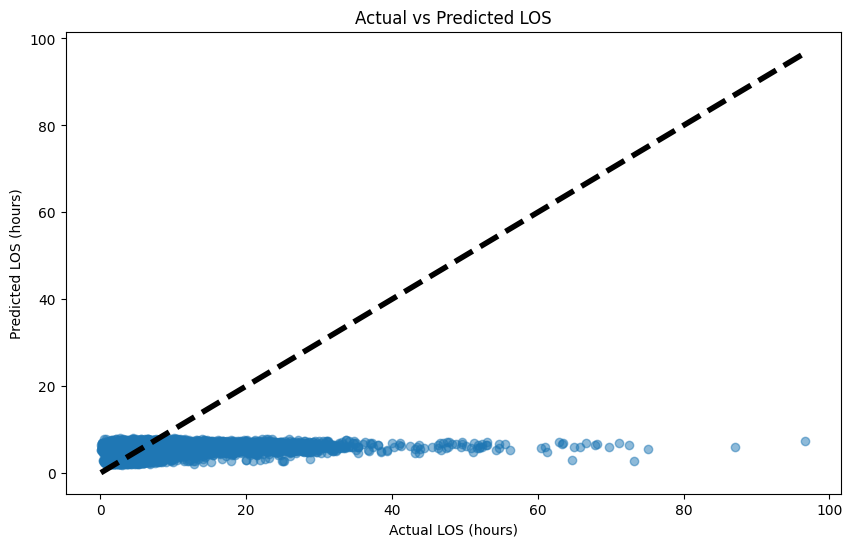

In [27]:

# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual LOS (hours)')
plt.ylabel('Predicted LOS (hours)')
plt.title('Actual vs Predicted LOS')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line for reference
plt.show()

In [28]:
# Function to classify hours into categories
def classify_hours(hours):
    if hours < 4.1:
        return '<4.1 hrs'
    elif 4.1 <= hours <= 6.9:
        return '4.1-6.9 hrs'
    else:
        return '>6.9 hrs'

In [29]:
# Apply the classification to both the predicted and actual values
y_pred_classes = np.array([classify_hours(hour) for hour in y_pred.flatten()])
y_test_classes = np.array([classify_hours(hour) for hour in y_test])

In [30]:
# Print the first few rows of the classified y_pred and y_test
print("First few classified predictions:", y_pred_classes[:5])
print("First few classified actual values:", y_test_classes[:5])

First few classified predictions: ['4.1-6.9 hrs' '<4.1 hrs' '4.1-6.9 hrs' '4.1-6.9 hrs' '4.1-6.9 hrs']
First few classified actual values: ['>6.9 hrs' '<4.1 hrs' '<4.1 hrs' '4.1-6.9 hrs' '>6.9 hrs']


In [31]:
# Generate classification report and confusion matrix
report = classification_report(y_test_classes, y_pred_classes, output_dict=True)
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes, labels=['<4.1 hrs', '4.1-6.9 hrs', '>6.9 hrs'])

In [32]:
# Print overall accuracy
print(f"Overall Accuracy: {accuracy_score(y_test_classes, y_pred_classes):.2f}")

# Print classification metrics for each class and overall
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes))

Overall Accuracy: 0.39
Classification Report:
              precision    recall  f1-score   support

 4.1-6.9 hrs       0.34      0.86      0.49      4817
    <4.1 hrs       0.73      0.20      0.31      4583
    >6.9 hrs       0.52      0.13      0.21      5436

    accuracy                           0.39     14836
   macro avg       0.53      0.40      0.34     14836
weighted avg       0.53      0.39      0.33     14836



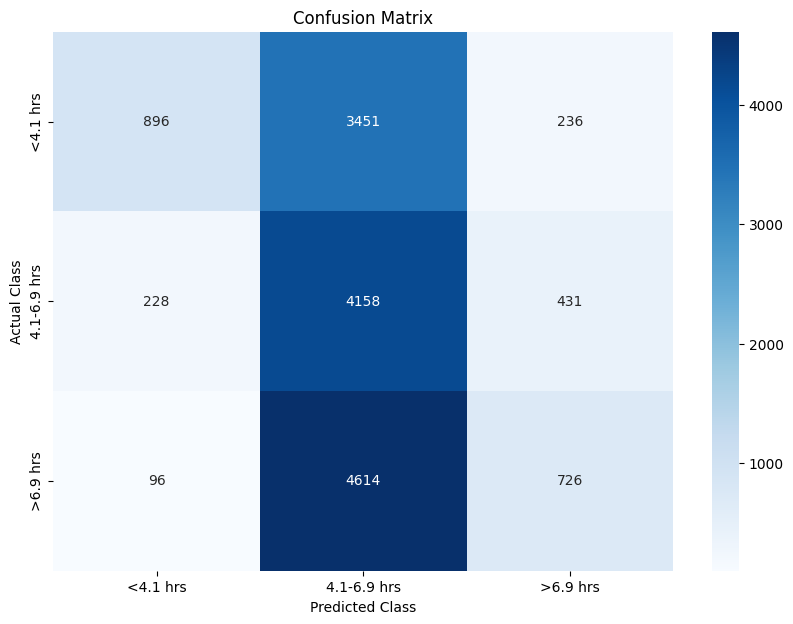

In [33]:
# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['<4.1 hrs', '4.1-6.9 hrs', '>6.9 hrs'], yticklabels=['<4.1 hrs', '4.1-6.9 hrs', '>6.9 hrs'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

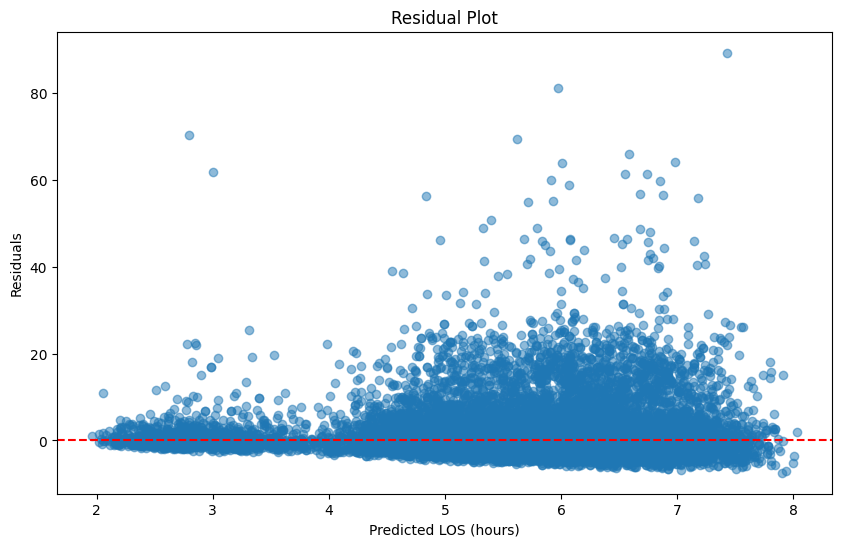

In [34]:
y_pred = y_pred.flatten()

y_test_array = y_test.values.flatten() if hasattr(y_test, 'values') else y_test

# Calculate residuals
residuals = y_test_array - y_pred

# Plotting the residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted LOS (hours)')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()